# Assignment 3: Character-Level Recurrent Neural Network by PyTorch

In this assignment, you are required to implement Character-Level RNN just as we have learned in the class. However, the difference is we use another dataset in this assignment.

Read through the tutorial [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) that builds a char-rnn that is used to classify names by their country of origin, which is introduced in the class. It is recommended that you can reproduce the tutorial’s results on the provided name dataset before moving on (notebook for Lecture 7), since the neural network architectures remain largely the same. Make sure you try your best to understand the dimensions of each layer (e.g. which ones can stay the same, and which are hyperparameters for us to tweak).

The process will be broken down into the following steps:
>1. Code implementation. (20 marks)
2. Experimentation and analysis (80 marks)

In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, print_function, division
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
import torch
import string
import random
import unicodedata
import time
import math
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#Verfiy file download
!head train/af.txt
!printf "\n"
!head val/af.txt
!printf "\n"
!head cities_test.txt
!printf "\n"
#Verify CUDA acceleration should print cuda:0
print(device)

garavshakh
kalishli
sarban kelay
dahan-e surunah
jahannum
morafeno
iskatel
zeri-chinar
taftebole
dzhafarabat

sikhtopa
laferronay
cham ghafur
souk tafetecht
panqash
siah sar bala
barah khan kili
vetob
kacari
kolga'i-i-bala

imam bakhsh amar
firoz laghari
glufishevo
qal`eh-ye ghazanfarkhani
nikolinalevada
kolkko
mbrostar i fierit
kharabanan-e sofla
stein bei nurnberg
jahangir bara

cuda:0


## Code Implementation (20 marks)

**You should implement all the following functions and you are not allowed to delete any of them. Of course you can add more functions based on this skeleton.**

In [3]:
#main_classify.py
import codecs
import math
import random
import string
import time
import numpy as np
import torch
from sklearn.metrics import accuracy_score

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''

languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_hidden = 128
n_languages = len(languages)
learning_rate = 5e-4

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

'''
Returns the words of the language specified by reading it from the data folder
Returns the validation data if train is false and the train data otherwise.
Return: A nx1 array containing the words of the specified language
'''


def getWords(baseDir, lang, train=True):
    folder = 'train/' if train else 'val/'
    with open(baseDir + folder + lang + '.txt', encoding='utf-8', errors='ignore') as file:
        lines = file.read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


'''
Returns a label corresponding to the language
For example it returns an array of 0s for af
Return: A nx1 array as integers containing index of the specified language in the "languages" array
'''


def getLabels(lang, length):
    index = [i for i, country in enumerate(languages) if country == lang][0]
    labels = [index for _ in range(length)]
    return labels


'''
Returns all the languages and labels after reading it from the file
Returns the validation data if train is false and the train data otherwise.
You may assume that the files exist in baseDir and have the same names.
Return: X, y where X is nx1 and y is nx1
'''


def readData(baseDir, train=True):
    all_words = []
    all_labels = []
    for lang in languages:
        words = getWords(baseDir, lang, train=train)
        labels = getLabels(lang, len(words))
        all_words += words
        all_labels += labels
    return all_words, all_labels



'''
Convert a line/word to a pytorch tensor of numbers
Refer the tutorial in the spec
Return: A tensor corresponding to the given line
'''


def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, len(all_letters), dtype=torch.float)
    for li, letter in enumerate(line):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


'''
Returns the category/class of the output from the neural network
Input: Output of the neural networks (class probabilities)
Return: A tuple with (language, language_index)
        language: "af", "cn", etc.
        language_index: 0, 1, etc.
'''


def category_from_output(output):
    top_n, top_i = output.topk(1)
    language_index = top_i[0].item()
    language = languages[language_index]
    outputs = (language, language_index)
    return outputs


'''
Get a random input output pair to be used for training 
Refer the tutorial in the spec
'''
def randomChoice(l):
    idx = random.randint(0, len(l) - 1)
    return l[idx], idx

def random_training_pair(X, y):
    line, idx = randomChoice(X)
    line_tensor = line_to_tensor(line)
    category = y[idx]
    one_hot = np.zeros(len(languages))
    one_hot[category] = 1
    category_tensor = torch.tensor(one_hot, dtype=torch.float)
    return category, line, category_tensor, line_tensor


'''
Input: trained model, a list of words, a list of class labels as integers
Output: a list of class labels as integers
'''


def predict(model, X, y):
    predictions = []
    hidden = model.init_hidden()
    for i in range(len(X)):
        line_tensor = line_to_tensor(X[i])
        for j in range(line_tensor.size()[0]):
            output, hidden = model(line_tensor[j], hidden)
        output = torch.max(output, 1)[1]
        predictions.append(output[0])
    return predictions, y


'''
Input: trained model, a list of words, a list of class labels as integers
Output: The accuracy of the given model on the given input X and target y
'''


def calculateAccuracy(model, X, y):
    y_pred, _ = predict(model, X, y)
    # 实验中，尝试使用GPU运行代码，但GPU运行会在这一步报错，暂时不知道怎么解决
    return accuracy_score(y, y_pred)

'''
Train the model for one epoch/one training word.
Ensure that it runs within 3 seconds.
Input: X and y are lists of words as strings and classes as integers respectively
Returns: You may return anything
'''


def trainOneEpoch(model, criterion, optimizer, X, y):
    category, line, category_tensor, line_tensor = random_training_pair(X, y)
    hidden = model.init_hidden()
    optimizer.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)
    category_tensor = category_tensor.view(1, len(languages))
    loss = criterion(output, torch.max(category_tensor, 1)[1])
    loss.backward()
    optimizer.step()

    return output, loss.item(), category, line, model


'''
Use this to train and save your classification model. 
Save your model with the filename "model_classify"
'''
# Init data
X, y = readData("./", train=True)
val_x, val_y = readData('./', train=False)

def run():
    

    # Init Network
    rnn = CharRNNClassify(n_letters, n_hidden, n_languages)

    # Init for training
    criterion = nn.NLLLoss()

    n_iters = 100000
    print_every = 5000
    plot_every = 1000

    # Keep track of losses for plotting
    current_loss = 0
    current_val_loss = 0
    all_losses = []
    all_val_losses = []

    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    start = time.time()
    # 实验中，效果的好坏全取决于学习率的调节，学习率为0.01时候极差，0.001会好些，之后暂未尝试
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    val_x, val_y = readData('./', train=False)

    for iter in range(1, n_iters + 1):

        output, loss, category, line, rnn = trainOneEpoch(rnn, criterion, optimizer, X, y)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == languages[category] else '✗ (%s)' % languages[category]
            print('%d %d%% (%s) %.4f %s / %s %s' % (
                iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
        category_i, _, val_tensor, val_line_tensor = random_training_pair(val_x, val_y)
        hidden = rnn.init_hidden()
        for j in range(val_line_tensor.size()[0]):
            val_output, hidden = rnn(val_line_tensor[j], hidden)
        val_category_tensor = val_tensor.view(1, n_languages)
        val_loss = criterion(val_output, torch.max(val_category_tensor, 1)[1]).item()
        current_val_loss += val_loss

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_val_losses.append(current_val_loss / plot_every)
            current_loss = 0
            current_val_loss = 0

    acc = calculateAccuracy(rnn, val_x, val_y)
    print('Validation Accuracy: ', acc)
    
    torch.save(rnn.state_dict(), './model_classify.pth')
    return all_losses, all_val_losses


In [4]:
#models.py
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNNClassify, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden=None):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.tanh(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

## Experimentation and Analysis (80 marks)

Complete the following analysis on the city names dataset.

1. Write code to output accuracy on the validation set (10 marks).  Use a confusion matrix plot to support your answer (10 marks).

In [5]:
all_losses, all_val_losses = run()

5000 5% (0m 47s) 0.7719 mingnandong / cn ✓
10000 10% (1m 37s) 0.8583 al hasaifin / fi ✓
15000 15% (2m 24s) 1.4924 sunjialao / cn ✓
20000 20% (3m 9s) 1.6969 sachimiao / ir ✗ (cn)
25000 25% (3m 57s) 0.3397 kafirki / fi ✓
30000 30% (4m 44s) 3.6717 bonteheuwel / de ✗ (za)
35000 35% (5m 31s) 0.7937 shaylahye bala / af ✓
40000 40% (6m 16s) 2.5688 arghandeye pa'in / ir ✗ (af)
45000 45% (7m 3s) 0.6295 fifihu / fi ✓
50000 50% (7m 51s) 1.1534 madafiyah / af ✗ (fi)
55000 55% (8m 39s) 2.2604 brzeziny podlesie / fr ✗ (in)
60000 60% (9m 28s) 0.6931 khawar kalan / pk ✓
65000 65% (10m 18s) 1.5565 shamsulabad / af ✗ (ir)
70000 70% (11m 4s) 2.4569 afamanso / cn ✗ (af)
75000 75% (11m 54s) 1.3605 einhof / in ✗ (de)
80000 80% (12m 42s) 0.0700 zastaryne / za ✓
85000 85% (13m 30s) 0.4457 etelavuokko / fi ✓
90000 90% (14m 17s) 0.7462 sant joan de caselles / de ✓
95000 95% (15m 6s) 3.6359 kafr elghunamiya / cn ✗ (af)
100000 100% (15m 54s) 0.4757 al afish / fi ✓
Validation Accuracy:  0.5555555555555556


/tmp/ipykernel_20585/2192470734.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + languages, rotation=90)
/tmp/ipykernel_20585/2192470734.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + languages)


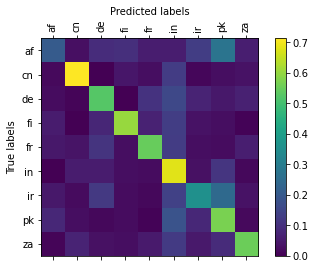

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

model = CharRNNClassify(n_letters, n_hidden, n_languages)
model.load_state_dict(torch.load('./model_classify.pth'))
model.eval()

confusion = torch.zeros(n_languages, n_languages)
n_confusion = 10000

for i in range(n_confusion):
    category_i, _, val_tensor, val_line_tensor = random_training_pair(val_x, val_y)
    hidden = model.init_hidden()
    for j in range(val_line_tensor.size()[0]):
        val_output, hidden = model(val_line_tensor[j], hidden)
    val_category_tensor = val_tensor.view(1, n_languages)
    guess_i = torch.max(val_output, 1)[1][0]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_languages):
    confusion[i] = confusion[i] / confusion[i].sum()
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.set_xlabel('Predicted labels')
ax.xaxis.set_label_position('top')
ax.set_ylabel('True labels')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [7]:
model = CharRNNClassify(n_letters, n_hidden, n_languages)
model.load_state_dict(torch.load('./model_classify.pth'))
model.eval()

test_dir = 'cities_test.txt'
with open(test_dir, encoding='utf-8', errors='ignore') as file:
    lines = file.read().strip().split('\n')
test_words = [unicodeToAscii(line) for line in lines]
outputs, _ = predict(model, test_words, None)
outputs = [x.item() for x in outputs]

with open('labels.txt', 'w') as file:
    for pred in outputs:
        file.write(languages[pred] + '\n')
    file.close()

2. Periodically compute the loss on the validation set, and create a plot with the training and validation loss as training progresses (20 marks).

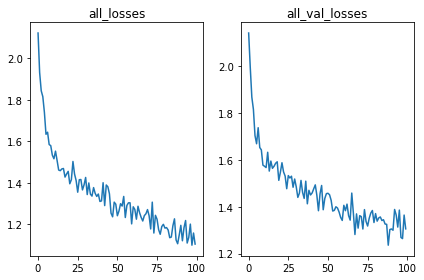

In [8]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(all_losses)
plt.title('all_losses')

plt.subplot(1, 2, 2)
plt.plot(all_val_losses)
plt.title('all_val_losses')

plt.tight_layout()
plt.show()

3. Experiment with the learning rate. You can try a few different learning rates and observe how this affects the loss. Another common practice is to drop the learning rate when the loss has plateaued. Use plots to explain your experiments and their effects on the loss (20 marks).


hidden_size = 128, learning_rate = 0.010000 :
5000 5% (0m 50s) 1.2445 gassino / fi ✗ (in)
10000 10% (1m 39s) 1.4249 yushengxu / pk ✗ (cn)
15000 15% (2m 27s) 7.1549 chatri / za ✗ (pk)
20000 20% (3m 16s) 4.9388 zhuding / fr ✗ (in)
25000 25% (4m 3s) 2.7096 lazaro lopez / de ✗ (za)
30000 30% (4m 50s) 1.3827 czaplice / fr ✗ (za)
35000 35% (5m 42s) 1.8248 shah said koruna / za ✗ (pk)
40000 40% (6m 32s) 4.7456 devon / ir ✗ (za)
45000 45% (7m 17s) 2.7526 svidino / pk ✗ (in)
50000 50% (8m 9s) 4.8286 ramna / fi ✗ (pk)
55000 55% (8m 59s) 3.8169 middelfourieskolk / af ✗ (de)
60000 60% (9m 48s) 0.8119 delegane sheykh cheragh / ir ✓
65000 65% (10m 42s) 1.5747 inbya / fi ✗ (in)
70000 70% (11m 32s) 3.0677 constanzana / af ✗ (za)
75000 75% (12m 22s) 3.6275 tapala / de ✗ (fi)
80000 80% (13m 13s) 7.4002 guzare nurullah khan / pk ✗ (af)
85000 85% (14m 2s) 2.8632 soi pungai / af ✗ (pk)
90000 90% (14m 52s) 3.6052 gangiwala / de ✗ (pk)
95000 95% (15m 40s) 1.1484 hacienda palma de vino / in ✗ (de)
100000 100

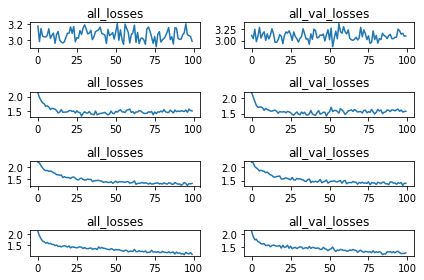

In [9]:
n_hidden = 128
learning_rate = 1e-2
print('\nhidden_size = %d, learning_rate = %f :' % (n_hidden, learning_rate))
all_losses1, all_val_losses1 = run()
learning_rate = 1e-3
print('\nhidden_size = %d, learning_rate = %f :' % (n_hidden, learning_rate))
all_losses2, all_val_losses2 = run()
learning_rate = 1e-4
print('\nhidden_size = %d, learning_rate = %f :' % (n_hidden, learning_rate))
all_losses3, all_val_losses3 = run()
learning_rate = 5e-4
print('\nhidden_size = %d, learning_rate = %f :' % (n_hidden, learning_rate))
all_losses4, all_val_losses4 = run()
plt.figure()
plt.subplot(4, 2, 1)
plt.plot(all_losses1)
plt.title('all_losses')

plt.subplot(4, 2, 2)
plt.plot(all_val_losses1)
plt.title('all_val_losses')

plt.subplot(4, 2, 3)
plt.plot(all_losses2)
plt.title('all_losses')

plt.subplot(4, 2, 4)
plt.plot(all_val_losses2)
plt.title('all_val_losses')

plt.subplot(4, 2, 5)
plt.plot(all_losses3)
plt.title('all_losses')

plt.subplot(4, 2, 6)
plt.plot(all_val_losses3)
plt.title('all_val_losses')

plt.subplot(4, 2, 7)
plt.plot(all_losses4)
plt.title('all_losses')

plt.subplot(4, 2, 8)
plt.plot(all_val_losses4)
plt.title('all_val_losses')

plt.tight_layout()
plt.show()

实验中，尝试了不同的learing_rate的设置，在实验过程中发现，learning rate设置为0.01时候，精确度Validation Accuracy:  0.131，训练效果很差，从loss的图像中可以看出，一直在震荡，不收敛。设置为0.001时候，精确度Validation Accuracy:  0.493，此时可以从loss图像上看到很好的收敛趋势，设置为0.0001时候，精确度Validation Accuracy:  0.618，最后二分法查看了以下设置为0.0005时：Validation Accuracy:  0.564，之后也用脚本进行了测试，发现learning rate设置在0.0001-0.0005之间时结果相对不错，但每次实验因为random_training_pair()函数存在的缘故，是存在波动的。

4. Experiment with the size of the hidden layer or the model architecture How does this affect validation accuracy (20 marks)?


hidden_size = 32, learning_rate = 0.000500 :
5000 5% (0m 22s) 2.1243 foyir / fr ✗ (ir)
10000 10% (0m 44s) 2.9273 panezai / za ✗ (pk)
15000 15% (1m 6s) 1.3214 goth kandani / za ✗ (pk)
20000 20% (1m 28s) 0.5002 igdluiartorfik / fi ✓
25000 25% (1m 50s) 0.8383 kerzaz / za ✓
30000 30% (2m 12s) 1.5608 laaken / de ✓
35000 35% (2m 34s) 1.1278 cabezarrubias / za ✓
40000 40% (2m 56s) 1.9025 changai / cn ✗ (pk)
45000 45% (3m 19s) 1.7204 chaumusson / cn ✗ (fr)
50000 50% (3m 41s) 1.6827 pibder point settlement / fr ✗ (in)
55000 55% (4m 3s) 1.0283 camp de banga / de ✓
60000 60% (4m 25s) 3.7540 spin masjid / ir ✗ (af)
65000 65% (4m 47s) 2.2265 barsurseine / fr ✗ (in)
70000 70% (5m 9s) 0.8367 izotkino / in ✓
75000 75% (5m 31s) 0.8015 chingpinghsien / cn ✓
80000 80% (5m 53s) 0.2209 goczaltki / za ✓
85000 85% (6m 15s) 4.3455 ostra haxbole / za ✗ (fi)
90000 90% (6m 37s) 0.1189 derecerkez / de ✓
95000 95% (6m 59s) 0.3828 abu zawr / za ✓
100000 100% (7m 21s) 0.2331 garcia de la cadena / de ✓
Validation Ac

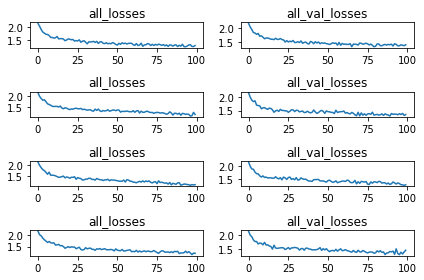

In [12]:
learning_rate = 5e-4
n_hidden = 32
print('\nhidden_size = %d, learning_rate = %f :' % (n_hidden, learning_rate))
all_losses1, all_val_losses1 = run()
n_hidden = 64
print('\nhidden_size = %d, learning_rate = %f :' % (n_hidden, learning_rate))
all_losses2, all_val_losses2 = run()
n_hidden = 128
print('\nhidden_size = %d, learning_rate = %f :' % (n_hidden, learning_rate))
all_losses3, all_val_losses3 = run()
n_hidden = 256
print('\nhidden_size = %d, learning_rate = %f :' % (n_hidden, learning_rate))
all_losses4, all_val_losses4 = run()
plt.figure()
plt.subplot(4, 2, 1)
plt.plot(all_losses1)
plt.title('all_losses')

plt.subplot(4, 2, 2)
plt.plot(all_val_losses1)
plt.title('all_val_losses')

plt.subplot(4, 2, 3)
plt.plot(all_losses2)
plt.title('all_losses')

plt.subplot(4, 2, 4)
plt.plot(all_val_losses2)
plt.title('all_val_losses')

plt.subplot(4, 2, 5)
plt.plot(all_losses3)
plt.title('all_losses')

plt.subplot(4, 2, 6)
plt.plot(all_val_losses3)
plt.title('all_val_losses')

plt.subplot(4, 2, 7)
plt.plot(all_losses4)
plt.title('all_losses')

plt.subplot(4, 2, 8)
plt.plot(all_val_losses4)
plt.title('all_val_losses')

plt.tight_layout()
plt.show()

实验中，我们用n_hidden这个变量去控制实验结果，我们尝试了32、64、128、256来做相关探索，32时Validation Accuracy:  0.475，64时Validation Accuracy:  0.571，128时Validation Accuracy:  0.571，256时Validation Accuracy:  0.456。在这个区间探索的结果是n_hidden不能设置太小，太小(例如32)会使精确度较低，因为隐层保留的信息更少，关键信息会下降。同样，太高也不合适(例如256)，一方面会使训练的难度增加，训练时间增长，另外也可能在隐层会引入一些噪声信息。在这个实验中，隐层设置为64-128之间比较合适。